# Tracking Russell 1000 index
<hr/>

In [1178]:
%run initlibs.py QuantTradingResearch dark
import ira
# import seaborn as sns
from sklearn import linear_model
from ira.analysis.kalman import kalman_regression_estimator, add_constant

%alphalab dark

from tools.utils.stat_helpers import cmp_to_norm
%run helpers.py

(c) 2017, AppliedAlpha Infrastructure for Quantitative Research and Analysis, ver. master: 0.1422


## Metrics for tracking error
<hr/>

In this reseach for measuring quality of our tracking model we will use divergence between index returns and tracking model returns (it's also known as tracking error). More formal definition is here:


$$
\omega = \sqrt{\frac{\sum_{i=1}^N (R_{b} - R_{p})^2} {N-1}} = Std(R_b - R_p)
$$

It's coded is in helpers.py file.

## Initial exploration of data
<hr/>

First we need to findout the structure of Russel 1000 index and see what shares it's constituted from. One of way is to look at specification of Russell1000 etf shares at https://www.ishares.com/us/products/239708/ishares-russell-1000-value-etf. I'll use last update (from 30-Jul-2020):

In [11]:
holdings = pd.read_csv('../data/30-06-2020.csv', sep=';').dropna()
holdings = holdings.sort_values('Weight (%)', ascending=False)

Let's see what are the most weighted assets in this index (we would select ones that constitute more than 95% of index). We will show only first 10 to keep the space.

In [1279]:
holdings[holdings['Weight (%)'] > np.percentile(holdings['Weight (%)'], 95)].head(10)

,Ticker,Name,Sector,Asset Class,Market Value,Weight (%),Notional Value,Shares,CUSIP,ISIN,SEDOL,Price,Location,Exchange,Currency,FX Rate,Maturity,Market Currency
0,BRKB,BERKSHIRE HATHAWAY INC CLASS B,Financials,Equity,"835,884,142.62",2.46,"835,884,142.62","4,682,562.00",084670702,US0846707026,2073390,178.51,United States,New York Stock Exchange Inc.,USD,1.0,-,USD
1,JNJ,JOHNSON & JOHNSON,Health Care,Equity,"771,309,985.88",2.27,"771,309,985.88","5,484,676.00",478160104,US4781601046,2475833,140.63,United States,New York Stock Exchange Inc.,USD,1.0,-,USD
2,JPM,JPMORGAN CHASE & CO,Financials,Equity,"684,282,455.42",2.01,"684,282,455.42","7,274,957.00",46625H100,US46625H1005,2190385,94.06,United States,New York Stock Exchange Inc.,USD,1.0,-,USD
3,INTC,INTEL CORPORATION CORP,Information Technology,Equity,"609,103,383.44",1.79,"609,103,383.44","10,180,568.00",458140100,US4581401001,2463247,59.83,United States,NASDAQ,USD,1.0,-,USD
4,VZ,VERIZON COMMUNICATIONS INC,Communication,Equity,"548,648,467.52",1.61,"548,648,467.52","9,951,904.00",92343V104,US92343V1044,2090571,55.13,United States,New York Stock Exchange Inc.,USD,1.0,-,USD
5,T,AT&T INC,Communication,Equity,"517,743,556.99",1.52,"517,743,556.99","17,126,813.00",00206R102,US00206R1023,2831811,30.23,United States,New York Stock Exchange Inc.,USD,1.0,-,USD
6,DIS,WALT DISNEY,Communication,Equity,"484,034,133.24",1.42,"484,034,133.24","4,340,724.00",254687106,US2546871060,2270726,111.51,United States,New York Stock Exchange Inc.,USD,1.0,-,USD
7,CSCO,CISCO SYSTEMS INC,Information Technology,Equity,"475,674,130.80",1.40,"475,674,130.80","10,198,845.00",17275R102,US17275R1023,2198163,46.64,United States,NASDAQ,USD,1.0,-,USD
8,XOM,EXXON MOBIL CORP,Energy,Equity,"454,577,190.08",1.34,"454,577,190.08","10,164,964.00",30231G102,US30231G1022,2326618,44.72,United States,New York Stock Exchange Inc.,USD,1.0,-,USD
9,BAC,BANK OF AMERICA CORP,Financials,Equity,"441,212,086.25",1.30,"441,212,086.25","18,577,351.00",060505104,US0605051046,2295677,23.75,United States,New York Stock Exchange Inc.,USD,1.0,-,USD


## Load historical data
<hr/>

We will load data for all symbols from Yahoo finance for having some freedom in experimenting. Also we will attach Russel1000 index (symbol ^RUI at YahooFinance)

In [65]:
data = load_yahoo_daily_data(np.append(holdings.Ticker.values, '^RUI'), '2016-01-01')

XTSLA MSFUT LGFB JWA LGFA FAU0 ESU0 

> Loaded 839 symbols


We wll use only daily closes prices so to keep memory a bit and drop unnecessary information we remain only Close prices and combain all data into single DataFrame object. For this pupose I have convenient method `retain_columns_and_join`

In [1179]:
trm = TrackingModel(data, index_name='^RUI', train_date='2020-06-30')

So now our data looks like that:

In [809]:
trm.closes.head()

,BRKB,JNJ,JPM,INTC,VZ,T,DIS,CSCO,XOM,BAC,...,PPC,USM,COHR,TDC,ENTG,MORN,AZPN,SFM,NEU,^RUI
2016-01-04,130.750000,88.409317,55.322636,29.930765,36.730564,25.882252,97.155785,22.660484,62.633877,14.983289,...,19.592167,38.730000,62.240002,26.250000,12.481384,75.587090,36.750000,26.780001,342.713135,1114.859985
2016-01-05,131.250000,88.778877,55.418297,29.789871,37.235050,26.063091,95.193428,22.557520,63.167557,14.983289,...,19.950342,38.130001,62.830002,25.520000,12.461852,75.710236,37.580002,26.980000,340.454346,1116.839966
2016-01-06,131.330002,88.330139,54.618279,29.129444,36.898659,26.024885,94.683952,22.317274,62.641960,14.664108,...,19.762300,37.500000,62.000000,24.480000,12.110263,75.643753,36.900002,25.910000,335.438965,1101.810059
2016-01-07,129.479996,87.300682,52.409550,28.037523,36.695995,25.604637,93.872604,21.802460,61.639301,14.135177,...,19.851843,37.259998,60.810001,23.660000,11.524282,74.314171,36.200001,25.799999,330.377533,1075.290039
2016-01-08,128.330002,86.368034,51.235615,27.746937,36.339329,25.627558,93.636742,21.261898,60.394070,13.861594,...,20.514467,37.430000,60.169998,23.469999,11.192226,73.459442,35.779999,25.520000,331.299500,1063.550049


We can also see how index data looks on OHLC plot

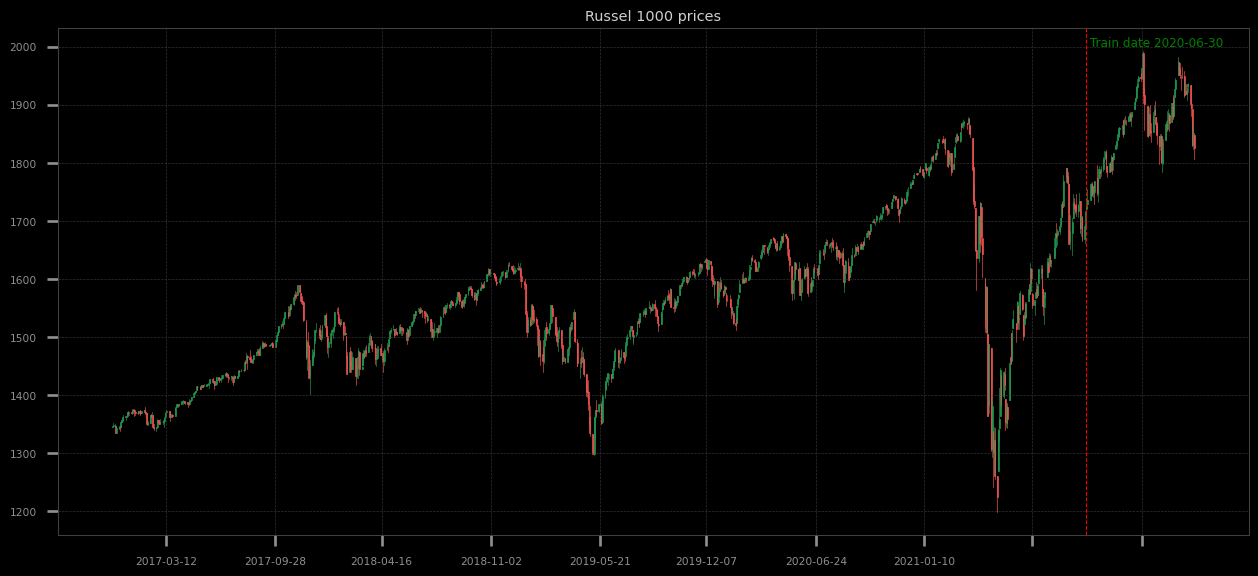

In [1300]:
fig(16, 7)
ohlc_plot(trm.index[trm.train_date - pd.Timedelta('3Y'):])
plt.axvline(trm.train_date, ls='--', color='r'); plt.text(trm.train_date, 2000, f' Train date {trm.train_date.strftime("%Y-%m-%d")}', color='green');
plt.title('Russel 1000 prices');

We can draw prices series for index and it's 25 most weighted shares on the same chart

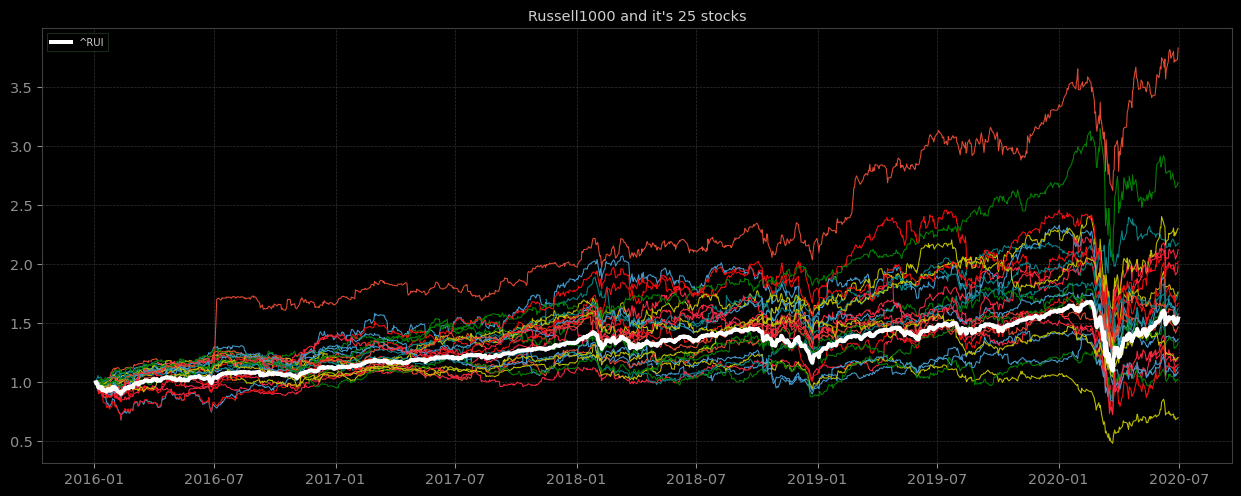

In [1280]:
constituents = holdings.Ticker[:25].values
shares, idx = trm.select(constituents).get_data('prices', where='train')

fig(16, 6)
plt.plot(norm(shares));
plt.plot(norm(idx), lw=3, c='w', label='^RUI'); plt.legend(); plt.title("Russell1000 and it's 25 stocks");

It's interesting to see how correlate prices for most weighted constituents and RUI index

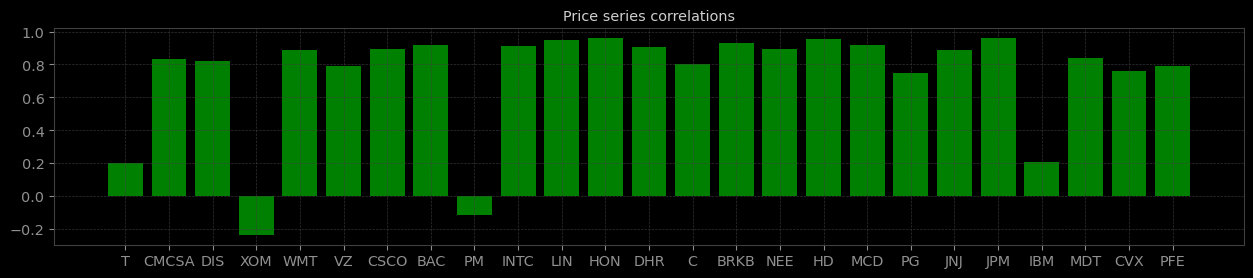

In [1281]:
corr_prices = pd.DataFrame.from_dict({s: np.corrcoef(shares.loc[:,s], idx)[0,1] for s in shares.columns}, orient='index')
fig(16, 3)
plt.bar(corr_prices.index, corr_prices[0].values, color='g'); plt.title('Price series correlations');

We can see that some assets demonstrate negative correlation with index (XOM, PM) and some have small (T, IBM). So we also need to use returns series instead of price series.

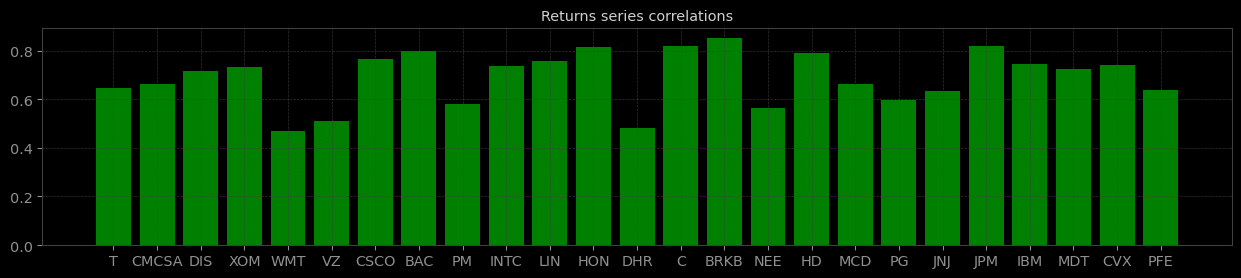

In [1282]:
shares_r, idx_r = trm.select(constituents).get_data('returns', where='train')
corr_rets = pd.DataFrame.from_dict({s: np.corrcoef(shares_r.loc[:,s], idx_r)[0,1] for s in shares_r.columns}, orient='index')

fig(16, 3)
plt.bar(corr_rets.index, corr_rets[0].values, color='g'); plt.title('Returns series correlations');

## Naive approach
<hr/>

First we'd like to see if we can just reproduce index using weights from structure file. It's interesting to see if we can get any reasonable tracking error just using simple method. 

We will use first 25 symbols to see how it performs

In [1283]:
class WeightingModel(Model):
    def predict(self, x, **kwargs):
        weights = np.array([holdings[holdings.Ticker==k]['Weight (%)'].values[0]/100 for k in holdings.Ticker if k in x.columns])
        weights = weights / sum(weights)
        return (x * weights).sum(axis=1)

So we'd just use weighted sum of shares returns as tracking portfolio

In [1284]:
wm_returns = trm.select(holdings.Ticker[:25].values).estimate(WeightingModel('Weights 25'), on='returns')

 -> TE (train): 0.36%  |  TE (test): 0.68%


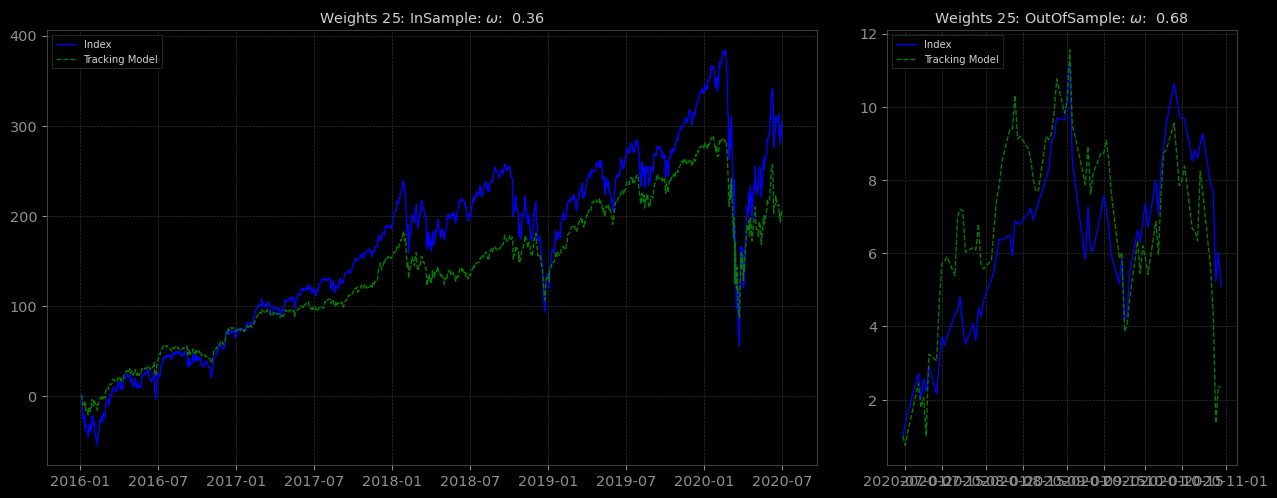

In [1285]:
fig(16, 6)
plot_results(wm_returns)

Now let's try to estimate optimal number of shares in simple weighting model that would result minimal tracking error on training period:

In [1170]:
w_runs = {}
for nc in tqdm(range(2, 300)):
    m = trm.select(holdings.Ticker[:nc].values).estimate(WeightingModel(), on='returns')
    w_runs[nc] = m.train.w

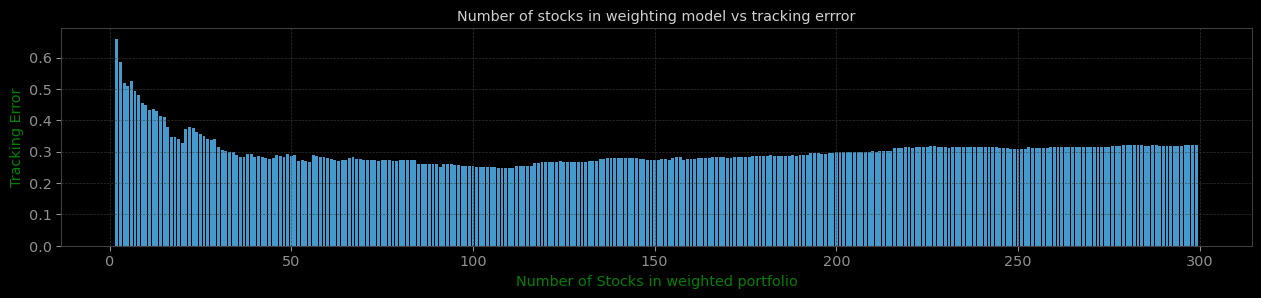

In [877]:
_rb = pd.DataFrame.from_dict(w_runs, orient='index')
fig(16, 3)
plt.bar(_rb.index, _rb[0]); plt.title('Number of stocks in weighting model vs tracking errror');
plt.xlabel('Number of Stocks in weighted portfolio'); plt.ylabel('Tracking Error');

We can see that optimal number of stocks is around 100, and more precisely: 

In [1229]:
print(' >> Optimal number of assets for weighted tracking portfolio: ', red(str(min(w_runs, key=w_runs.get))))

 >> Optimal number of assets for weighted tracking portfolio:  110


In [1230]:
wm_returns_best = trm.select(holdings.Ticker[:min(w_runs, key=w_runs.get)].values).estimate(WeightingModel('Weights Optimal'), on='returns')

 -> TE (train): 0.25%  |  TE (test): 0.65%


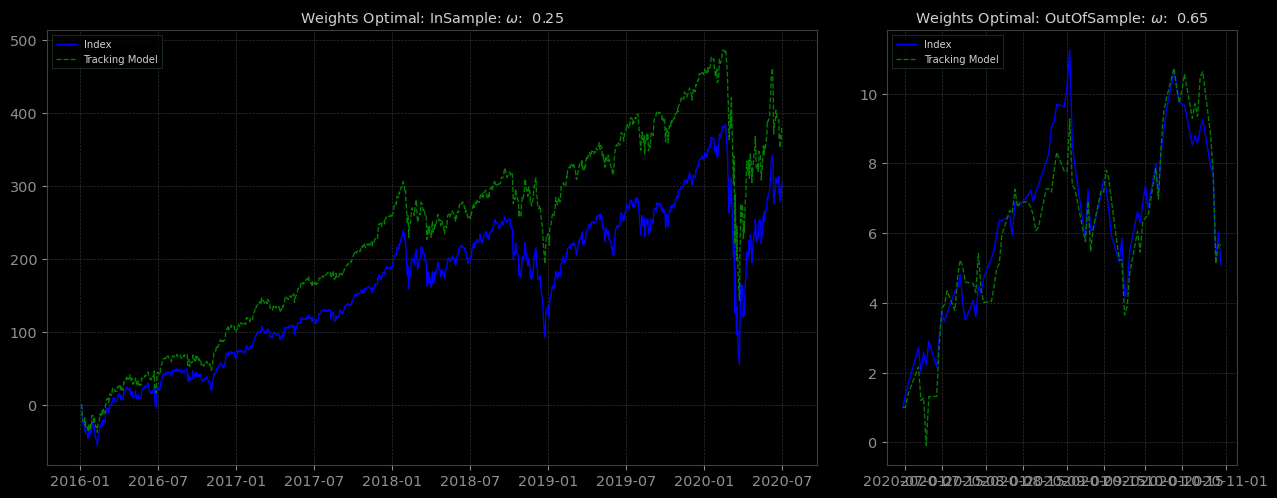

In [1286]:
fig(16, 6); plot_results(wm_returns_best)

<font color='orange'> Conclusion on weighting model</font>

We found that using portfolio consisting 110 most weighted stocks tracks index better compared to just using 25 constituents.

# Linear regression model
<hr/>

We can see that expression for tracking error (***TE***) has the same form as standard error of estimation (***SEoE***) for regression model. So applying machine learning regression model with objective to minimize ***SEoE*** would automatically lead to minimize ***TE***.
First we could try linear model and see if we can decrease of TE.


## Raw linear regression
<hr/>

First we will try to apply linear regression model in form

$$
    R_{index}(t) = \beta + \sum_{k=1}^{N} \alpha_k R_{k}(t) + \varepsilon(t)
$$

Here we will not take in account intercept ($\beta==0$)

In [1185]:
class LinearModel(Model):
    def fit(self, x, y):
        clf = linear_model.LinearRegression(fit_intercept=False)
        clf.fit(x, y)
        return clf 

 -> TE (train): 0.28%  |  TE (test): 0.64%


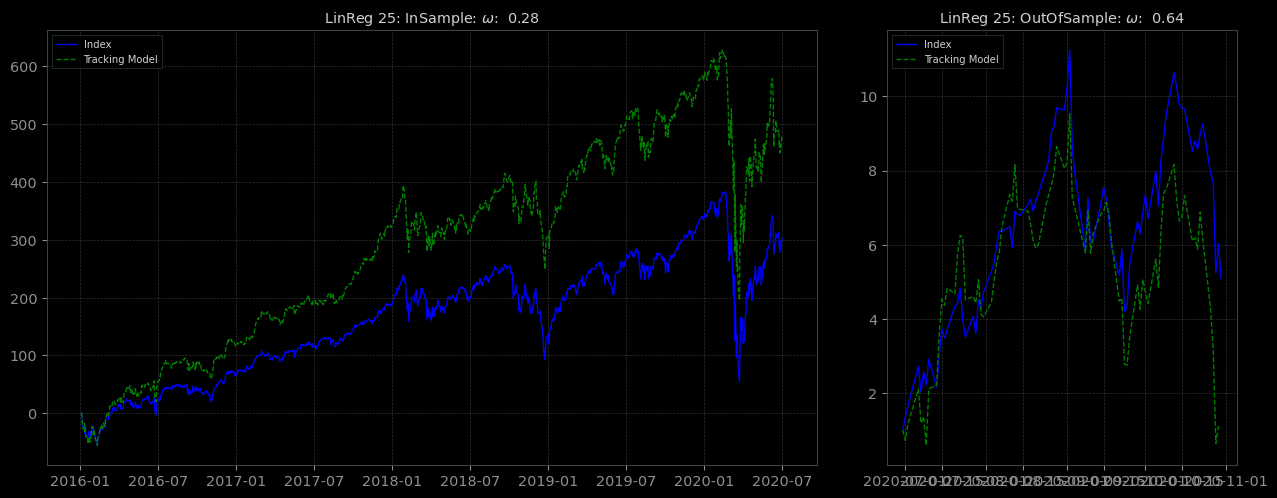

In [1186]:
linear_returns = trm.select(holdings.Ticker[:25].values).estimate(LinearModel('LinReg 25'), on='returns')

fig(16, 6)
plot_results(linear_returns)

 -> TE (train): 0.14%  |  TE (test): 0.45%


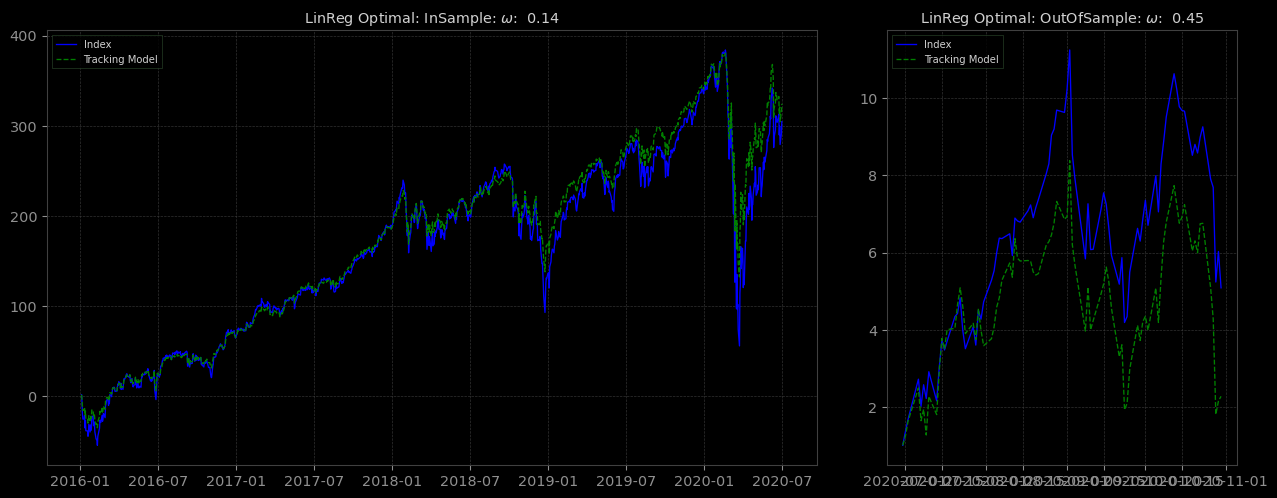

In [1232]:
linear_returns_best = trm.select(holdings.Ticker[:100].values).estimate(LinearModel('LinReg Optimal'), on='returns')

fig(16, 6);  plot_results(linear_returns_best)

## Lasso linear regression
<hr/>

Now we try to plug L1 regularization into our linear model doing so we try to eliminate assets whith lower explanaition power

In [1189]:
class LassoModel(Model):
    def fit(self, x, y):
        best_score, best_model = 0, None
        for a in np.logspace(-10, 1, 10):
            model = linear_model.Lasso(alpha=a, fit_intercept=False, max_iter=20000).fit(x, y)
            score = model.score(x, y)
            if score > best_score:
                best_score, best_model = score, model
        return best_model

 -> TE (train): 0.28%  |  TE (test): 0.64%


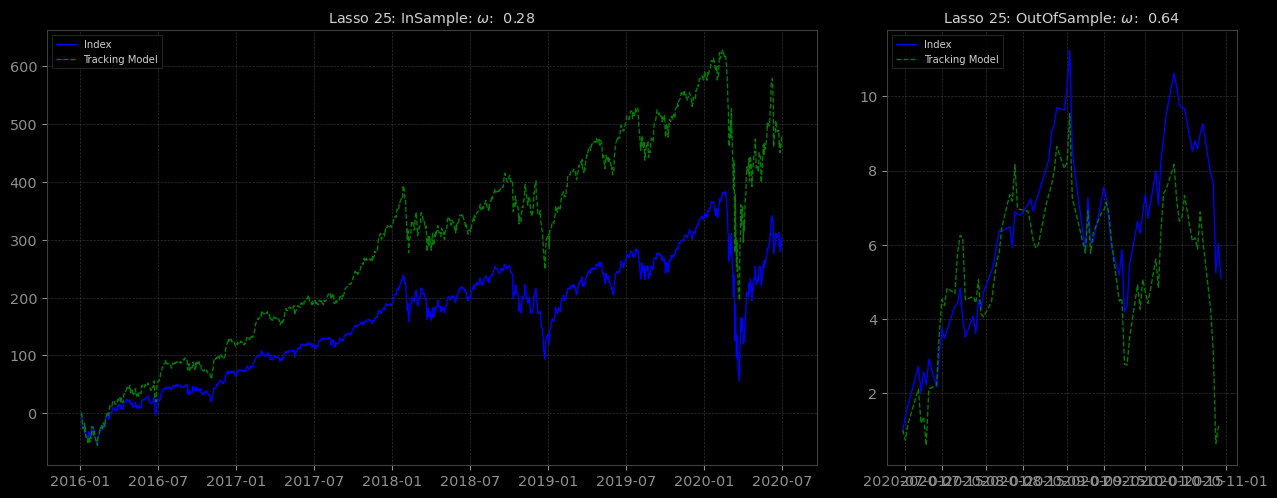

In [1190]:
lassom_returns = trm.select(holdings.Ticker[:25].values).estimate(LassoModel('Lasso 25'), on='returns')

fig(16, 6)
plot_results(lassom_returns)

 -> TE (train): 0.14%  |  TE (test): 0.45%


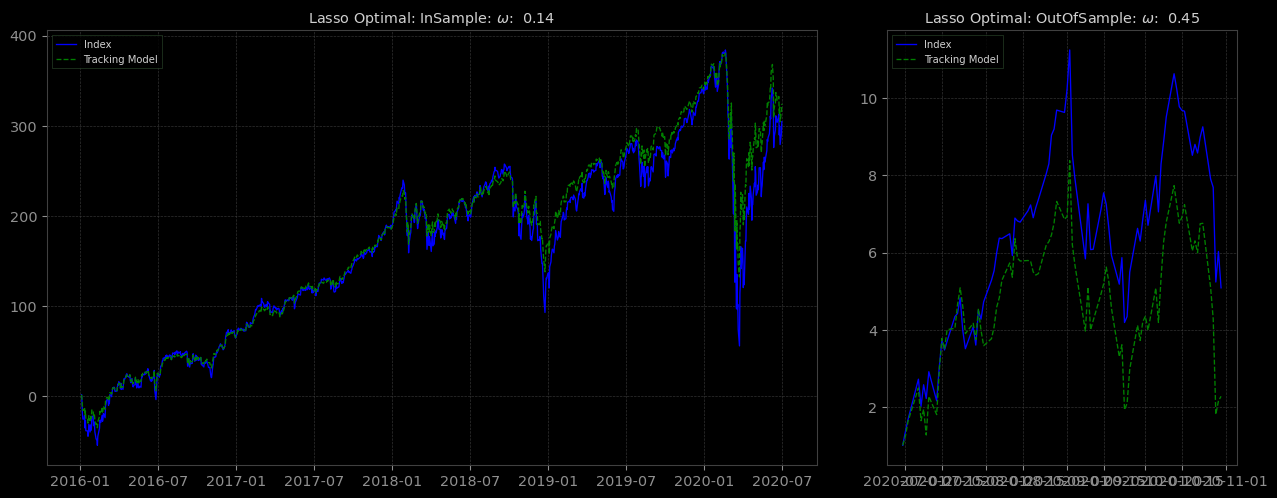

In [1233]:
lassom_returns_best = trm.select(holdings.Ticker[:100].values).estimate(LassoModel('Lasso Optimal'), on='returns')

fig(16, 6); plot_results(lassom_returns_best)

# Kalman Filter for estimating regression model
<hr/>

Kalman Filter (KF) can optimally estimate dynamic beta (actually weights of our tracking portfolio) where measurement noise covariance and state noise covariance are assumed to be known.

The state estimate depends on the choice of parameter matrices F, H, Q and R.

These can be estimated by maximizing the Gaussian log likelihood function.

$$
\mathscr{L} = -\frac{1}{2} (N \ln(2\pi) + \ln(\sigma) + \frac{\varepsilon^2}{\sigma})
$$
N - number of observations

In [1235]:
class KFModel(Model):
    def predict(self, x, y):
        warmup_time = slice(5, None)
        b, err, evars = kalman_regression_estimator(x.values, y.values, 1e-5, 1, intercept=False)
        self.err = pd.Series(err, index=y.index)[warmup_time]
        self.var = pd.Series(np.sqrt(evars), index=y.index)[warmup_time]
        self.b = pd.DataFrame(b.T, index=y.index, columns=x.columns)[warmup_time]
        return pd.DataFrame(x.values * b.T, index=y.index)[warmup_time].sum(axis=1)

/usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/analysis/kalman.py:53: RuntimeWarning:

divide by zero encountered in true_divide



 -> TE (train): 1.23%  |  TE (test): 291.91%


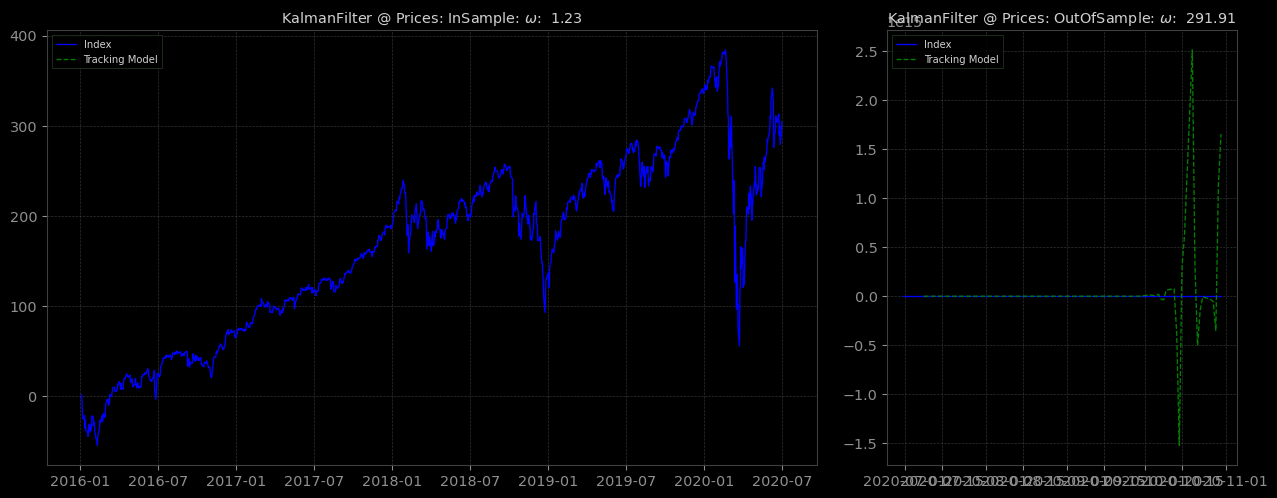

In [1236]:
kf_returns = trm.select(holdings.Ticker[:25].values).estimate(KFModel('KalmanFilter @ Prices'), on='returns')

fig(16, 6); plot_results(kf_returns)

 -> TE (train): 0.01%  |  TE (test): 0.01%


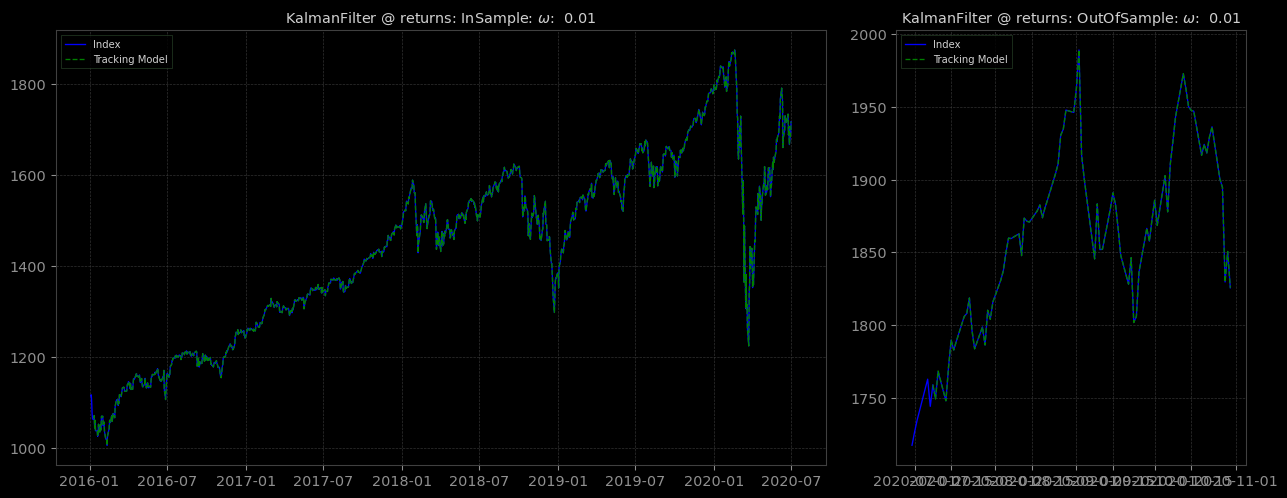

In [1237]:
kf_prices = trm.select(holdings.Ticker[:25].values).estimate(KFModel('KalmanFilter @ returns'), on='prices')

fig(16, 6); plot_results(kf_prices)

## <font color='green'> Trading model based on tracking error </font>
<hr/>

The idea behind this is very simple - we suggest that our tracking portfolio should reflect index 

In [1287]:
trm2 = TrackingModel(data, index_name='^RUI', train_date='2020-03-30')
kft = trm2.select(holdings.Ticker[:100].values).estimate(KFModel('KF for Arbitrage'), on='prices')

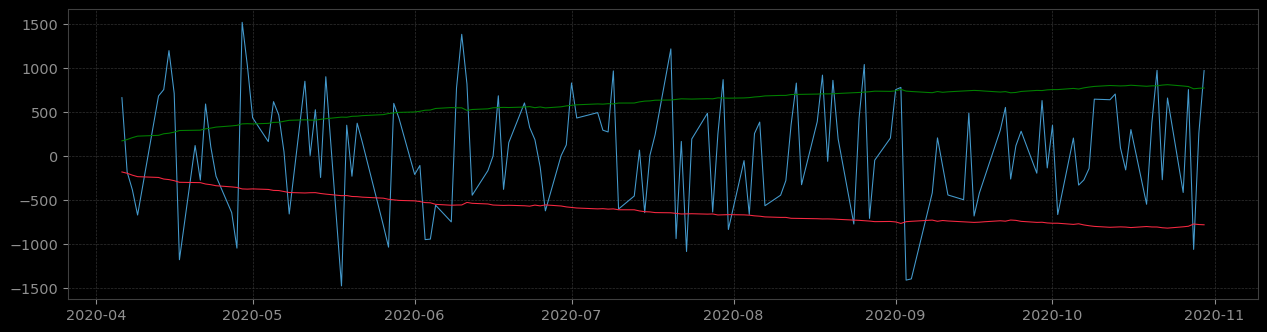

In [1288]:
fig(16, 4)
plt.plot(kft.model.err)
plt.plot(2*kft.model.var); plt.plot(-2*kft.model.var)

Z-Score

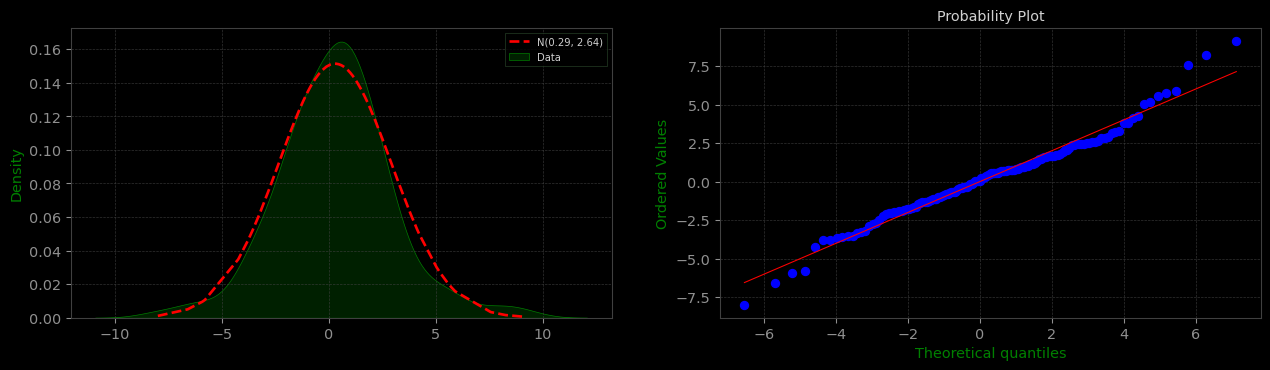

In [1289]:
fig(16, 4); cmp_to_norm(kft.model.err / kft.model.var)

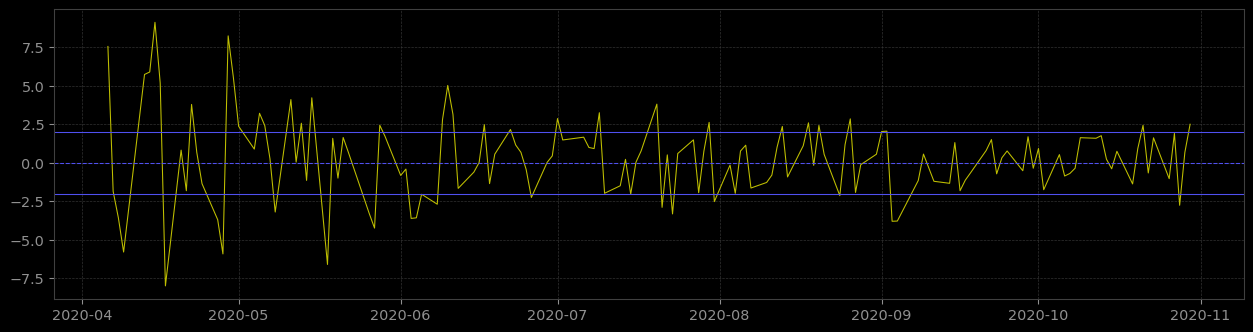

In [1291]:
fig(16, 4); plt.plot(kft.model.err / kft.model.var, c='y'); plt.axhline(2); plt.axhline(-2); plt.axhline(0, ls='--')

<font color='green' size=2> <b> Trading model (statistical arbitrage) </b> </font>
<hr/>

In [1292]:
signals = arbitrage_trading(kft, 1, -1, 10_000)

In [1293]:
signals.head()

,MDLZ,CMCSA,PGR,EXC,CAT,ANTM,USB,HON,ECL,SCHW,...,PNC,DLR,SRE,WFC,IBM,CVX,AXP,RTX,TMUS,^RUI
2020-04-06 15:59:00,165,288,74,271,18,-48,286,-2,-22,299,...,33,-8,9,365,17,89,47,118,58,-10000
2020-04-07 15:59:00,-166,-289,-75,-272,-19,47,-287,1,21,-300,...,-34,7,-10,-366,-18,-90,-48,-119,-59,10000
2020-04-08 15:59:00,-166,-290,-75,-272,-19,48,-288,1,22,-300,...,-34,7,-10,-367,-18,-90,-48,-119,-59,10000
2020-04-09 15:59:00,-167,-291,-75,-273,-18,48,-289,2,22,-301,...,-34,8,-9,-368,-18,-90,-48,-120,-59,10000
2020-04-13 15:59:00,165,289,74,271,18,-49,287,-2,-23,299,...,33,-8,9,366,17,89,47,118,58,-10000


<font color='orange'> <b> Run signals on simulator </b> </font>

Statistic,Model
Gain (USD):,2907999.78
CAGR (%):,55.496
Sharpe:,1.560
Sortino:,2.881
Calmar:,4.720
MaxDD (%):,11.757
MaxDD On Init BP (%):,13.163
MaxDD (USD):,1316294.207
MaxDD days:,30 days
MaxDD start:,2020-05-12

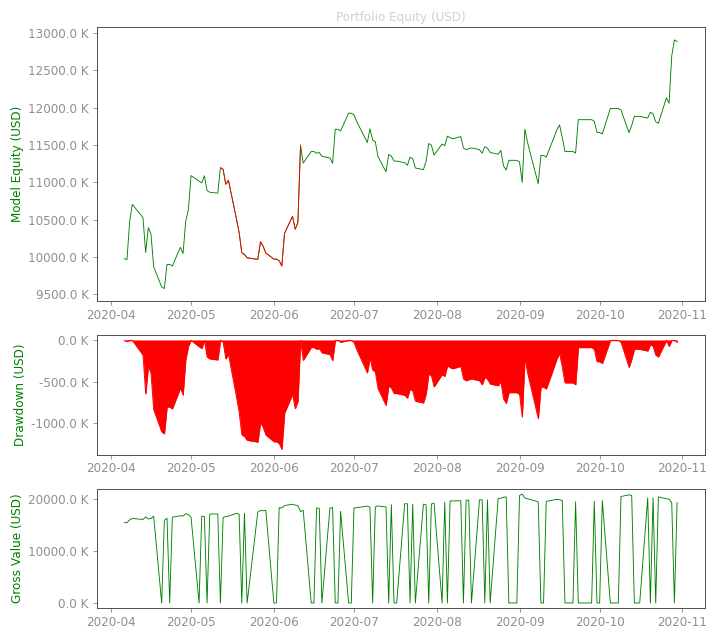

<Figure size 720x640 with 0 Axes>

In [1296]:
p = z_test_signals_inplace(signals, trm2.data, 'stock', spread=1, verbose=False)
tearsheet(p, 10_000_000)

# <font color='orange'>Error tracking for all methods and conclusion</font>
<hr/>

In [1275]:
pd.DataFrame.from_dict({w.description: w.test.w for w in [wm_returns, wm_returns_best, linear_returns, linear_returns_best, lassom_returns, lassom_returns_best, kf_prices]}, 
                       orient='index', columns=['TrackingError']).sort_values('TrackingError')

,TrackingError
KalmanFilter @ returns,0.009199
Lasso Optimal,0.452880
LinReg Optimal,0.452880
LinReg 25,0.640701
Lasso 25,0.640701
Weights Optimal,0.651159
Weights 25,0.683808


> So we can see that using Kalman filter would give best results for proxy portfolio tracking index. Standard linear models also would show good metric.